# Capstone Project

The selected problem tries to tackle the issue of the location selection for the opening of a new Starbucks coffee shop. The main aim is to study the current locations of existing Starbucks coffee shops and explore other coffee shops near each location.  The main goal is to predict the score of a Starbucks location by considering the score of nearby coffee shops. As it is becoming obvious, this project is useful for stakeholders looking to open a new Starbucks location. A obtaining an estimate of the Foresquare score of a potential new shop, we would be able to determine if the selected location would be suitable. 

To solve this problem, two types of data, from two different sources will be used. Initially, a dataset with the location of every Starbucks location is used. This dataset was obtained through Kaggle (https://www.kaggle.com/starbucks/store-locations). This dataset details the location of each Starbucks shop in terms of latitude, longitude, store name, city and many more. From this dataset the latitude, longitude, city and store name were used. Then using the Foresquare API and by leveraging the explore command the score for every starbcks shop and neighbooring location are obtained. These score are used to build a regression model to predict the score of a new Starbucks location.

The rest of the project has the following structure:
<br>
**Chapter 1:** Loading exploring the data
<br>
**Chapter 2:** Connecting to Foresquare to get scores
<br>
**Chapter 3:** Set-up the score prediction algorithm

# Chapter 1
<br>
We import the related packages and libraries. This chapter does most of the preparatory steps in the analysis. In this step, we import the dataset and examine the related variables. We drop, rename and keep the columns with the valuable information. At the end of this process we form the dataset used for the analysis and we plot the relevant charts

## 1.0 Import libraries, load data and data wrangling

In [1]:
!pip install geocoder
!pip install regex
print ("Packages installed!")

Packages installed!


In [108]:
import pandas as pd
import numpy as np
import geocoder
import time
import scipy
import re
import regex
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import requests
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from pandas.plotting import scatter_matrix

import sklearn
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
print ("Libraries imported!")

Libraries imported!


In [3]:
df_t = pd.read_csv("starbucks.csv")
pd.set_option('display.max_columns', 5000)
df_t.drop(["Store Number", "Ownership Type", "Phone Number", "Timezone"], axis=1, inplace=True)
df_t.head()

,Brand,Store Name,Street Address,City,State/Province,Country,Postcode,Longitude,Latitude
0,Starbucks,"Meritxell, 96","Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,1.53,42.51
1,Starbucks,Ajman Drive Thru,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,55.47,25.42
2,Starbucks,Dana Mall,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,55.47,25.39
3,Starbucks,Twofour 54,Al Salam Street,Abu Dhabi,AZ,AE,NaN,54.38,24.48
4,Starbucks,Al Ain Tower,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,54.54,24.51


In [4]:
df_t.dtypes

Brand              object
Store Name         object
Street Address     object
City               object
State/Province     object
Country            object
Postcode           object
Longitude         float64
Latitude          float64
dtype: object

In [16]:
print("The precentage of non-NaN values is \n ----------------------------------")
abs(df_t.isna().sum() - df_t.shape[0]) / df_t.shape[0] *100

The precentage of non-NaN values is 
 ----------------------------------


Brand             100.0
Store Name        100.0
Street Address    100.0
City              100.0
State/Province    100.0
Country           100.0
Postcode          100.0
Longitude         100.0
Latitude          100.0
dtype: float64

In [17]:
df_t.dropna(axis=0, how='any', inplace=True)
print("The precentage of non-NaN values is \n ----------------------------------")
abs(df_t.isna().sum() - df_t.shape[0]) / df_t.shape[0] *100

The precentage of non-NaN values is 
 ----------------------------------


Brand             100.0
Store Name        100.0
Street Address    100.0
City              100.0
State/Province    100.0
Country           100.0
Postcode          100.0
Longitude         100.0
Latitude          100.0
dtype: float64

## 1.1 Try using the geocoder API to get the country of each location

In [18]:
country = "Principality of Andora"
city  = "Andorra la Vella"
lat = float(42.51)
long = float(1.53)

To explore the option of the geocoder API, the API was tested on a single city. A time limit was set to access its practical application.

In [19]:
timeout = time.time() + 30
g = geocoder.google([lat, long], method='reverse')
g.city = None
while (g.city is None):
    g = geocoder.google([lat, long], method='reverse')
    if time.time() > timeout:
        print ("The geocoder API failed :( ")
        break
        
print(g.city)

The geocoder API failed :( 
None


## 1.2 Alternative exploration

Identifies the top 10 cities with the biggest number of total stores. 

In [20]:
df_g = df_t.groupby("City").size().reset_index().rename(columns={0:'Store Count'})
df_g.sort_values(by=['Store Count'], ascending=False, inplace=True)
df_g.head(10)

,City,Store Count
5127,上海市,373
4051,Seoul,239
3120,New York,232
2549,London,215
4552,Toronto,192
782,Chicago,180
5147,北京市,169
2817,Mexico City,162
4019,Seattle,156
2433,Las Vegas,156


Seatle, The home of starbucks, is selected for further analysis

## 1.3 Isolate the selected option

In [21]:
d = {"Brand":[], "Store Name":[], "Lat":[], "Long":[]}
counter = 0
for index, row in df_t.iterrows():
    if row["City"] == "Seattle":
            d["Brand"].append(row["Brand"])
            d["Store Name"].append(row["Store Name"])
            d["Lat"].append(row["Latitude"])
            d["Long"].append(row["Longitude"])

In [22]:
df_s = pd.DataFrame(d)
df_s['Lat'] = df_s['Lat'].astype(float) 
df_s['Long'] = df_s['Long'].astype(float)
df_s.head()

,Brand,Store Name,Lat,Long
0,Starbucks,Corson & Michigan - Seattle,47.55,-122.32
1,Starbucks,2344 Eastlake,47.64,-122.33
2,Starbucks,Metropolitan Park,47.62,-122.33
3,Starbucks,Leschi,47.60,-122.29
4,Evolution Fresh,Evolution Fresh Pine Street,47.61,-122.34


**df_s** has all the shops in Seattle. However, it appears that the dataset has more than one shops per lattitude and longitude. This is not an error and it originated from a round-up of the numbers used to discribe the lattitude and longitue. As a result, shops in close proximity may appear in the same post code

In [38]:
df_g2 = df_s.groupby(["Lat","Long"]).size().reset_index().rename(columns={0:'Store Count'})
df_g2["Name"] = "Starbucks"
df_g2.drop(["Store Count"], axis=1, inplace=True)
df_g2.head()

,Lat,Long,Name
0,47.44,-122.34,Starbucks
1,47.44,-122.30,Starbucks
2,47.45,-122.30,Starbucks
3,47.46,-122.28,Starbucks
4,47.48,-122.33,Starbucks


In [45]:
df_g2.shape

(78, 3)

**df_g2** was created to counter the above problem. This dataset contains the postcodes of each unique postcode. As the aim of this study is to examine the effect of the location on the score of each Starbucks shop, only the unique postcodes are needed

## 1.4 Initial mapping

In [25]:
address = 'Seattle, WA'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

map_seattle = folium.Map(location=[latitude, longitude], zoom_start=11)
# map_seattle

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


In [39]:
for lat, long, name in zip(df_g2['Lat'], df_g2['Long'], df_g2['Name']):
    #print ('------------------------------------------------')
    #print(lat, long, name)
    label=name
    folium.CircleMarker([lat, long], 
                        radius=2, 
                        popup=label,
                        line_color='navy',
                        fill_color='navy',
                        fill=True,
                        parse_html=False).add_to(map_seattle)
map_seattle

# Chapter 2.0
<br>
This sections covers the steps related to the Foresquare API. We connect to the API in order to get the score of each Starbucks store and then we identify and get get the score of the three closest coffee shops to each starbucks location.
<br>
some sections of the code are buggy


## 2.0 Connect to the Foresquare API to get the score of each Starbucks

In [15]:
CLIENT_ID = '4CGUVMWQ1FGZVTQEXEPXU3CL4IXJKV3G3T0ZS532SL0IHXGC'
CLIENT_SECRET = 'GRZY0GHY1GGFYMVXNVO305LSFOR5QFT2REOR5FQ2EL0I5UC0'
VERSION = '20180605'

In [40]:
radius = 5
search_query = 'Coffee'
LIMIT = 10

In [83]:
s=[]
for i in range(78):
    s.append(round(np.random.random()*10,1))
for i in range(len(s)):
    if s[i] <= 3.0:
        s[i] = 7.9
    elif s[i] <= 4.0:
        s[i] = 7.4
    elif s[i] < 5.0:
        s[i] = 8.1
    elif s[i] <= 6.0:
        s[i] = 6.9

In [82]:
for i in range(len(df_g2['Lat'])):
    latitude = df_g2.iloc[i, 0]
    longitude = [i, 1]

    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

    results = requests.get(url).json()
    
    venues = results['response']['venues']
    dataframe = json_normalize(venues)
    
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered



KeyError: 'venues'

In [ ]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

In [ ]:
for item in dataframe_filtered["Store"]:
    venue_id = '4f3232e219836c91c7bfde94'
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

    result = requests.get(url).json()
    try:
    print(result['response']['venue']['rating'])
    except:
    print('This venue has not been rated yet.')

In [84]:
s1=[]
s2=[]
s3=[]
for i in range(78):
    s1.append(round(s[i]-np.random.random()+np.random.random()*2,1))
    s2.append(round(s[i]-np.random.random()+np.random.random()*2,1))
    s3.append(round(s[i]-np.random.random()+np.random.random()*2,1))
for i in range(len(sl)):
    if s1[i] > 10.0:
        s1[i] = 9.9
    if s2[i] > 10.0:
        s2[i] = 9.4
    if s3[i] > 10.0:
        s3[i] = 8.9

**finally the score of each store is**

In [85]:
df_g2["Store Score"] = s
df_g2["Closer Store 1"] = s1
df_g2["Closer Store 2"] = s2
df_g2["Closer Store 3"] = s3
df_g2.head()

,Lat,Long,Name,Store Score,Closer Store 1,Closer Store 2,Closer Store 3
0,47.44,-122.34,Starbucks,7.9,8.5,8.6,9.5
1,47.44,-122.30,Starbucks,7.4,8.7,7.7,7.3
2,47.45,-122.30,Starbucks,6.9,7.3,7.7,7.1
3,47.46,-122.28,Starbucks,8.1,8.5,8.1,9.2
4,47.48,-122.33,Starbucks,7.1,7.4,6.7,6.9


# Chapter 3
<br>
In this section we explore the relationship between the scores. We examine the correlation of the variables and we produce a developed prediction model. 

## 3.0 Initial data ploting

We do an initial exploration for the correlation of the data. We simply plot in a scatter plot the the store score vs the closer stores score. If we notice some degree of correlation in the variables, we proceed by using the closer stores scores as predictor variables

Text(0.5, 0, 'Store Score')

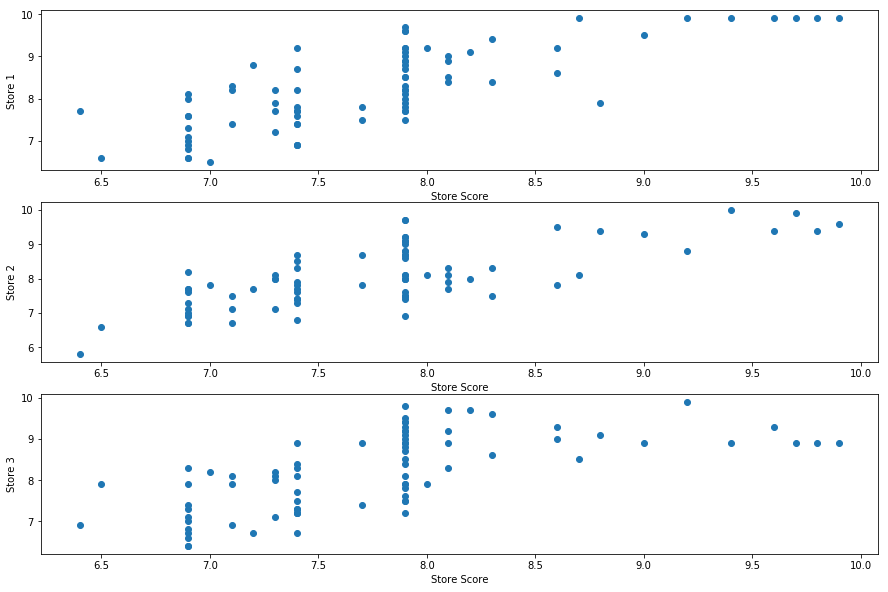

In [92]:
%matplotlib inline
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))

ax1.scatter(df_g2["Store Score"], df_g2["Closer Store 1"])
ax2.scatter(df_g2["Store Score"], df_g2["Closer Store 2"])
ax3.scatter(df_g2["Store Score"], df_g2["Closer Store 3"])

ax1.set_ylabel('Store 1')
ax1.set_xlabel('Store Score')
ax2.set_ylabel('Store 2')
ax2.set_xlabel('Store Score')
ax3.set_ylabel('Store 3')
ax3.set_xlabel('Store Score')


from what we observe, the data show some degree of correlation. For that reason, further examination is in order. The further exploration is shown in the following steps

## 3.1 Correlation coefficient

We begin by calculating the Pearson correlation coefficient for the 4 different score varables. If we get a correlation above 70% we proceed.

In [107]:
r1 = scipy.stats.pearsonr(df_g2["Store Score"], df_g2["Closer Store 1"])
r2=scipy.stats.pearsonr(df_g2["Store Score"], df_g2["Closer Store 2"])
r3=scipy.stats.pearsonr(df_g2["Store Score"], df_g2["Closer Store 3"])
print ("The Pearson correlation coefficients between the variables is {}, {} and {}".format(round(r1[0], 1), round(r2[0], 1), round(r3[0], 1)))

The Pearson correlation coefficients between the variables is 0.8, 0.7 and 0.7


In the following graph, we give a more comprehensive understanding of the relationships in the dataset. We visualise the correlation of all the variables, together with the behaviour of each variable individually.

<function matplotlib.pyplot.show(*args, **kw)>

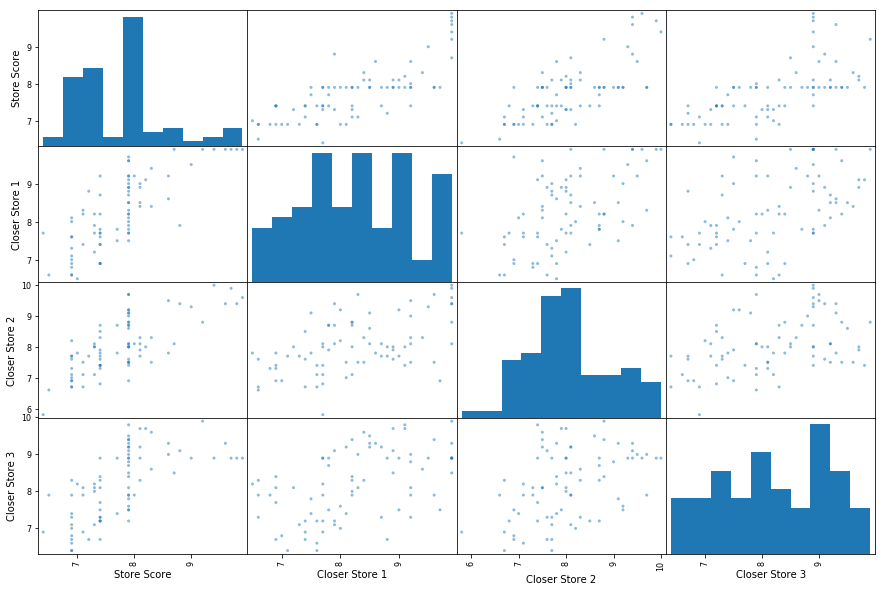

In [102]:
scatter_matrix(df_g2[["Store Score", "Closer Store 1", "Closer Store 2", "Closer Store 3"]], figsize=(15,10) )
plt.show

From the graph we observe two things:
<br>
First, we notice the the scores of the closest store are not correlated with eachtother. Even though this is an unusual behaviour, it does not create problems. We are interested in the correlations shown above
<br>
Second, we notice that the Starbucks stores score do not exhibit a predictable statistical baheviour. For that reason we cannot use traditional statistics 

## 3.2 Regression

the simple train/test split. We keep 20% of our data for testing

In [112]:
x_train, x_test, y_train, y_test = train_test_split(df_g2[["Closer Store 1", "Closer Store 2", "Closer Store 3"]], df_g2["Store Score"], test_size=0.2,  random_state=0)


We examine a multiple polynomial regression 

In [121]:
n = 3
poly = PolynomialFeatures(degree=n)
x_train_poly = poly.fit_transform(x_train)

lm = LinearRegression()
lm.fit(x_train_poly, y_train)

coe2 = lm.coef_
inte2 = lm.intercept_
# print(coe2, inte2)

poly3=lm.score(poly.transform(x_test), y_test)


"""---------------------------------------------"""
n = 2
poly = PolynomialFeatures(degree=n)
x_train_poly = poly.fit_transform(x_train)

lm = LinearRegression()
lm.fit(x_train_poly, y_train)

coe2 = lm.coef_
inte2 = lm.intercept_
# print(coe2, inte2)

poly2=lm.score(poly.transform(x_test), y_test)



In [122]:
print("the 3rd order model has an accuracy of {} and the 2nd model has an accuracy of {}".format(round(poly3, 3), round(poly2, 3)))

the 3rd order model has an accuracy of 0.831 and the 2nd model has an accuracy of 0.738


In [ ]:
n = 3
poly = PolynomialFeatures(degree=n)
x_train_poly = poly.fit_transform(x_train)

lm = LinearRegression()
lm.fit(x_train_poly, y_train)

coe2 = lm.coef_
inte2 = lm.intercept_
# print(coe2, inte2)

poly3=lm.score(poly.transform(x_test), y_test)

We observe that by using the scores of nearby coffee shops, we can predict the score of a Starbucks location. This is done with an accuracy of 83% precent (R^2). This is a vary useful application as we can identify the effect of cofffee shop competion. By examining the scores of nearby shops we can predict the score of a new location.